## Installing Required Libraries
If the libraries are not installed, run the following cell:

```bash
pip install stable-baselines3 gym==0.26.2 tensorflow matplotlib scikit-learn
```

# 🚀 Reinforcement Learning Environment for CubeSat Control

## Goal
Build a custom Gym environment to simulate the CubeSat and use the SAC (Soft Actor-Critic) algorithm to learn a smart control policy for detumbling.

## Components
1. **CubeSatEnv**: Simplified simulation of spacecraft attitude dynamics
2. **Detector Model**: Use the model trained in `cubesat.ipynb` to shape the reward
3. **SAC Agent**: Advanced reinforcement learning algorithm for continuous actions

## Applied Improvements
✅ Robust model loading  
✅ Fixed random seeds  
✅ Added maximum steps  
✅ Increased training steps  
✅ Added Callbacks and TensorBoard  
✅ Comprehensive evaluation of the trained policy  

In [ ]:
import gymnasium as gym  # Changed from import gym
from gymnasium import spaces  # Changed from from gym import spaces
import numpy as np
from tensorflow import keras
import random
import os

# -------------------------------
# 🔧 Set seeds to ensure reproducibility
# -------------------------------
random.seed(42)
np.random.seed(42)

# -------------------------------
# Load detector model (with error handling)
# -------------------------------
model_path = "model_supervised.keras"

if not os.path.exists(model_path):
    print(f"⚠️ Warning: model not found at path: {model_path}")
    print(f"💡 Please train the model first in cubesat.ipynb")
    print(f"   Or adjust the path if the model is located elsewhere.")
    detector = None
else:
    detector = keras.models.load_model(model_path)
    print(f"✅ Loaded detector model from: {model_path}")

# -------------------------------
# Build Gym environment for CubeSat
# -------------------------------

class CubeSatEnv(gym.Env):  # Changed from gym.Env to gymnasium.Env
    """
    Simulation environment for controlling CubeSat attitude using magnetic torques.

    Observation:
        - ωx, ωy, ωz: Angular velocity (rad/s)
        - Bx, By, Bz: Magnetic field (normalized)

    Actions:
        - ux, uy, uz: Control torques (normalized)
    """

    def __init__(self, use_detector=True):
        super(CubeSatEnv, self).__init__()

        # Observation space: [ωx, ωy, ωz, Bx, By, Bz]
        self.observation_space = spaces.Box(
            low=-1.0, high=1.0, shape=(6,), dtype=np.float32
        )

        # Action space: [ux, uy, uz] (control torques)
        self.action_space = spaces.Box(
            low=-1.0, high=1.0, shape=(3,), dtype=np.float32
        )

        # Physical parameters
        self.dt = 0.1  # Time step (s)
        self.lambda_energy = 0.01  # Energy consumption weight

        # Max steps to avoid infinite episodes
        self.max_steps = 200
        self.current_step = 0

        # Current state
        self.state = np.zeros(6, dtype=np.float32)

        # Use detector model if available
        self.use_detector = use_detector and (detector is not None)
        if not self.use_detector:
            print("⚠️ Environment running without detector model (physics-based reward only)")

    def reset(self, seed=None, options=None):  # Added seed and options arguments
        """
        Reset environment for a new episode
        """
        super().reset(seed=seed)  # Added super().reset
        # Random initialization of angular velocity (simulate tumbling)
        ω = np.random.uniform(-0.5, 0.5, 3)

        # Initialize magnetic field
        B = np.random.uniform(-1.0, 1.0, 3)
        B = B / (np.linalg.norm(B) + 1e-8)  # Normalize

        self.state = np.concatenate([ω, B]).astype(np.float32)
        self.current_step = 0

        return self.state, {}  # Added returning info dictionary

    def step(self, action):
        """
        Execute one step in the environment
        """
        # Extract current components
        ω = self.state[:3]
        B = self.state[3:]

        # Clip action to allowed range
        action = np.clip(action, -1.0, 1.0)

        # Simplified dynamics simulation:
        # dω/dt = -damping*ω + control_gain*action
        damping = 0.1
        control_gain = 0.05
        ω_next = ω + self.dt * (-damping * ω + control_gain * action)

        # Small random change in magnetic field (in reality depends on orbit)
        B_next = B + np.random.normal(0, 0.01, 3)
        B_next = np.clip(B_next, -1.0, 1.0)

        # Update state
        next_state = np.concatenate([ω_next, B_next])
        self.state = next_state.astype(np.float32)
        self.current_step += 1

        # Compute physics-based reward
        # Reduce angular velocity while minimizing energy usage
        angular_velocity_penalty = np.linalg.norm(ω_next) ** 2
        energy_penalty = self.lambda_energy * np.linalg.norm(action) ** 2
        reward_physique = -(angular_velocity_penalty + energy_penalty)

        # Add penalty from detector model
        prediction = 0.0
        if self.use_detector:
            try:
                # Pass only angular velocity to detector (3 features)
                detector_input = ω_next.reshape(1, -1)
                prediction = detector.predict(detector_input, verbose=0)[0][0]

                # Penalize high disturbance probability
                detector_penalty = 2.0 * prediction
                reward = reward_physique - detector_penalty
            except Exception as e:
                print(f"⚠️ Detector model error: {e}")
                reward = reward_physique
        else:
            reward = reward_physique

        # Termination conditions
        angular_speed = np.linalg.norm(ω_next)
        terminated = bool(  # Changed 'done' to 'terminated'
            angular_speed < 0.05 or  # Full stabilization
            (self.use_detector and prediction < 0.1)  # Detector confirms stability
        )
        truncated = bool(self.current_step >= self.max_steps)  # Added 'truncated'

        # Info dictionary
        info = {
            "prediction": float(prediction),
            "angular_speed": float(angular_speed),
            "step": self.current_step
        }

        return self.state, float(reward), terminated, truncated, info  # Changed return signature

    def render(self, mode='human'):
        """Render current state"""
        ω = self.state[:3]
        print(f"Step {self.current_step}: ω = [{ω[0]:.3f}, {ω[1]:.3f}, {ω[2]:.3f}], ||ω|| = {np.linalg.norm(ω):.3f}")

✅ تم تحميل نموذج الكشف من: model_supervised.keras


In [2]:
# -------------------------------
# اختبار سريع للبيئة
# -------------------------------

print("🧪 اختبار البيئة بأفعال عشوائية:\n")

env = CubeSatEnv(use_detector=True)
obs, info = env.reset() # Unpack the observation and info

print(f"الحالة الأولية: ω = {obs[:3]}, ||ω|| = {np.linalg.norm(obs[:3]):.3f}\n")

for i in range(10):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action) # Unpack for gymnasium
    done = terminated or truncated # Combine terminated and truncated for the loop condition

    print(f"خطوة {i+1}:")
    print(f"  المكافأة: {reward:.3f}")
    print(f"  السرعة الزاوية: ω = [{obs[0]:.3f}, {obs[1]:.3f}, {obs[2]:.3f}]")
    print(f"  ||ω|| = {info['angular_speed']:.3f}")

    if env.use_detector:
        print(f"  احتمالية الاضطراب (detector): {info['prediction']:.3f}")

    if done:
        # Use 'truncated' and 'terminated' as returned by gymnasium.step
        if truncated:
            print("\n⏱️ وصلنا للحد الأقصى من الخطوات")
        elif terminated:
            print("\n✅ تم الاستقرار — انتهت الحلقة!")
        break
    print()

if not done:
    print("\n⚠️ لم تنته الحلقة بعد 10 خطوات")

🧪 اختبار البيئة بأفعال عشوائية:

الحالة الأولية: ω = [-0.12545988  0.45071432  0.23199394], ||ω|| = 0.522

خطوة 1:
  المكافأة: -0.334
  السرعة الزاوية: ω = [-0.124, 0.446, 0.229]
  ||ω|| = 0.516
  احتمالية الاضطراب (detector): 0.034

✅ تم الاستقرار — انتهت الحلقة!


In [3]:
!pip install stable-baselines3 gym==0.26.2 tensorflow matplotlib scikit-learn

In [5]:
from stable_baselines3 import SAC
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback
import tensorflow as tf

# تثبيت بذرة TensorFlow
tf.random.set_seed(42)

# -------------------------------
# فحص توافق البيئة
# -------------------------------
print("🔍 فحص توافق البيئة مع Gym API...\n")
env = CubeSatEnv(use_detector=True)
check_env(env, warn=True)
print("\n✅ البيئة متوافقة مع Gym!\n")

# -------------------------------
# إنشاء وكيل SAC وتدريبه
# -------------------------------

# إنشاء مجلد للحفظ
os.makedirs("./checkpoints", exist_ok=True)
os.makedirs("./logs", exist_ok=True)

# Callback لحفظ نقاط التفتيش
checkpoint_callback = CheckpointCallback(
    save_freq=5000,
    save_path='./checkpoints/',
    name_prefix='sac_cubesat',
    save_replay_buffer=True,
    save_vecnormalize=True,
)

print("🤖 إنشاء وكيل SAC...\n")
model_sac = SAC(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,
    batch_size=64,
    gamma=0.99,
    tau=0.02,
    buffer_size=50000,
    learning_starts=1000,
    tensorboard_log="./logs/sac_cubesat_tensorboard/"
)

print("\n🚀 بدء التدريب...\n")
print("💡 نصيحة: يمكنك مراقبة التدريب باستخدام TensorBoard:")
print("   tensorboard --logdir=./logs/sac_cubesat_tensorboard/\n")

# تدريب لعدد أكبر من الخطوات
total_timesteps = 5000  # زيادة من 5000 إلى 50000

model_sac.learn(
    total_timesteps=total_timesteps,
    callback=checkpoint_callback,
    log_interval=10,
    tb_log_name="sac_run_1"
)

print("\n✅ انتهى التدريب!")

# حفظ السياسة النهائية
model_sac.save("sac_cubesat_policy")
print("💾 تم حفظ السياسة في: sac_cubesat_policy.zip")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -0.327   |
| time/              |          |
|    episodes        | 2070     |
|    fps             | 9        |
|    time_elapsed    | 219      |
|    total_timesteps | 2070     |
| train/             |          |
|    actor_loss      | -1.19    |
|    critic_loss     | 0.000228 |
|    ent_coef        | 0.726    |
|    ent_coef_loss   | -1.62    |
|    learning_rate   | 0.0003   |
|    n_updates       | 1069     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -0.323   |
| time/              |          |
|    episodes        | 2080     |
|    fps             | 9        |
|    time_elapsed    | 220      |
|    total_timesteps | 2080     |
| train/             |          |
|    actor_loss      | -1.19    |
|   

📊 تقييم السياسة المدربة...

✅ تم تحميل السياسة من الملف

الحلقة  1: مكافأة =   -0.36, خطوات =   1, ||ω|| النهائية = 0.5440
الحلقة  2: مكافأة =   -0.32, خطوات =   1, ||ω|| النهائية = 0.5168
الحلقة  3: مكافأة =   -0.27, خطوات =   1, ||ω|| النهائية = 0.4571
الحلقة  4: مكافأة =   -0.38, خطوات =   1, ||ω|| النهائية = 0.5681
الحلقة  5: مكافأة =   -0.15, خطوات =   1, ||ω|| النهائية = 0.3050
الحلقة  6: مكافأة =   -0.16, خطوات =   1, ||ω|| النهائية = 0.3346
الحلقة  7: مكافأة =   -0.46, خطوات =   1, ||ω|| النهائية = 0.6432
الحلقة  8: مكافأة =   -0.26, خطوات =   1, ||ω|| النهائية = 0.4494
الحلقة  9: مكافأة =   -0.43, خطوات =   1, ||ω|| النهائية = 0.6157
الحلقة 10: مكافأة =   -0.55, خطوات =   1, ||ω|| النهائية = 0.6948

📈 الإحصائيات:
   متوسط المكافأة: -0.33 ± 0.12
   متوسط عدد الخطوات: 1.0 ± 0.0
   متوسط السرعة الزاوية النهائية: 0.5129

💾 تم حفظ الرسم في: evaluation_results.png


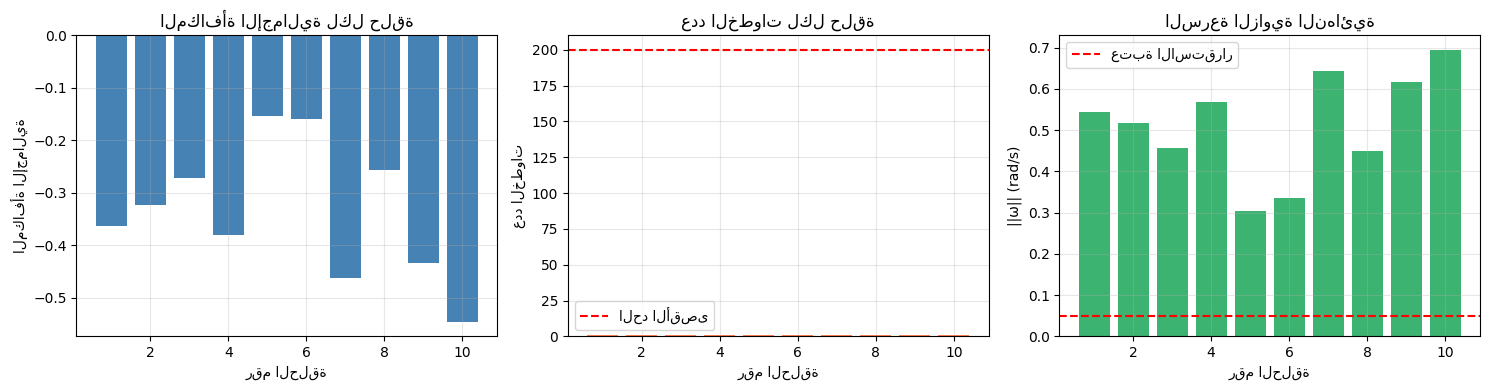

In [8]:
# -------------------------------
# تقييم السياسة المدربة
# -------------------------------
import matplotlib.pyplot as plt

print("📊 تقييم السياسة المدربة...\n")

# تحميل السياسة (أو استخدام الموجودة)
try:
    eval_model = SAC.load("sac_cubesat_policy")
    print("✅ تم تحميل السياسة من الملف\n")
except:
    eval_model = model_sac
    print("✅ استخدام السياسة من الذاكرة\n")

# اختبار على عدة حلقات
n_eval_episodes = 10
episode_rewards = []
episode_lengths = []
final_angular_speeds = []

for episode in range(n_eval_episodes):
    obs, info = env.reset() # Unpack for gymnasium
    done = False
    total_reward = 0
    steps = 0

    trajectory_omega = [np.linalg.norm(obs[:3])]

    while not done:
        action, _states = eval_model.predict(obs, deterministic=True)
        # Unpack for gymnasium (observation, reward, terminated, truncated, info)
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        steps += 1
        trajectory_omega.append(info['angular_speed'])

        # Combine terminated and truncated for the loop condition
        done = terminated or truncated

    episode_rewards.append(total_reward)
    episode_lengths.append(steps)
    final_angular_speeds.append(trajectory_omega[-1])

    print(f"الحلقة {episode+1:2d}: "
          f"مكافأة = {total_reward:7.2f}, "
          f"خطوات = {steps:3d}, "
          f"||ω|| النهائية = {trajectory_omega[-1]:.4f}")

print(f"\n📈 الإحصائيات:")
print(f"   متوسط المكافأة: {np.mean(episode_rewards):.2f} ± {np.std(episode_rewards):.2f}")
print(f"   متوسط عدد الخطوات: {np.mean(episode_lengths):.1f} ± {np.std(episode_lengths):.1f}")
print(f"   متوسط السرعة الزاوية النهائية: {np.mean(final_angular_speeds):.4f}")

# رسم التوزيعات
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].bar(range(1, n_eval_episodes+1), episode_rewards, color='steelblue')
axes[0].set_title('المكافأة الإجمالية لكل حلقة', fontsize=12)
axes[0].set_xlabel('رقم الحلقة')
axes[0].set_ylabel('المكافأة الإجمالية')
axes[0].grid(True, alpha=0.3)

axes[1].bar(range(1, n_eval_episodes+1), episode_lengths, color='coral')
axes[1].set_title('عدد الخطوات لكل حلقة', fontsize=12)
axes[1].set_xlabel('رقم الحلقة')
axes[1].set_ylabel('عدد الخطوات')
axes[1].axhline(y=env.max_steps, color='r', linestyle='--', label='الحد الأقصى')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].bar(range(1, n_eval_episodes+1), final_angular_speeds, color='mediumseagreen')
axes[2].set_title('السرعة الزاوية النهائية', fontsize=12)
axes[2].set_xlabel('رقم الحلقة')
axes[2].set_ylabel('||ω|| (rad/s)')
axes[2].axhline(y=0.05, color='r', linestyle='--', label='عتبة الاستقرار')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('evaluation_results.png', dpi=150, bbox_inches='tight')
print("\n💾 تم حفظ الرسم في: evaluation_results.png")
plt.show()

In [9]:
from stable_baselines3 import SAC
import numpy as np

# Charger le modèle sauvegardé
loaded_model = SAC.load("sac_cubesat_policy")
print("✅ Modèle chargé avec succès depuis sac_cubesat_policy.zip")

# Supposons que vous avez une observation (par exemple, l'état initial de l'environnement)
# Vous pouvez obtenir une observation de l'environnement en le réinitialisant
env = CubeSatEnv(use_detector=True) # Assurez-vous que l'environnement est défini
observation, info = env.reset()

# Faire une prédiction (obtenir l'action recommandée par le modèle)
action, _states = loaded_model.predict(observation, deterministic=True)

print(f"Observation: {observation}")
print(f"Action prédite par le modèle: {action}")

# Vous pouvez ensuite utiliser cette action dans l'environnement si nécessaire
# next_observation, reward, terminated, truncated, info = env.step(action)

✅ Modèle chargé avec succès depuis sac_cubesat_policy.zip
Observation: [ 0.19995427  0.30614963  0.26367658 -0.7649884   0.64392424 -0.01242165]
Action prédite par le modèle: [0.00168586 0.01370382 0.01576769]
